# Characteristic of Irrecoverable Loans
## by Amanda Legi

## Investigation Overview

> Through this investigation, I would like to understand the characteristic of borrowers that may cause loans to be irrecoverable.

## Dataset Overview

> The dataset will focus on 14897 records of irrecoverable loans. In the analysis, irrecoverable loans refer to loans having principal amount that remains uncollected after any recoveries, which is recorded as Nett Principal Loss. This is one of the attributes that we will be looking at. Other attributes are Debt-to-Income Ratio, Credit Rating, Employment Status, and Income Range. Some data points with missing Debt-to-Income Ratio and Credit Rating were removed from the dataset.

In [17]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [18]:
# load in the dataset into a pandas dataframe
prosper_loan = pd.read_csv('prosperLoanData.csv')

In [19]:
# Rename columns that are having spaces in between
prosper_loan.rename(columns={"ProsperRating (numeric)": "ProsperRatingNumeric", 
                             "ProsperRating (Alpha)": "ProsperRatingAlpha",
                             "ListingCategory (numeric)": "ListingCategoryNumeric",
                             "TradesNeverDelinquent (percentage)": "TradesNeverDelinquentPercentage"}, inplace=True)

In [20]:
# Convert NC (No Credit) values in CreditGrade column to NaN
prosper_loan['CreditGrade'] = prosper_loan['CreditGrade'] .replace('NC', np.nan)

In [21]:
# Combine credit rating columns from CreditGrade (records before 2009) and ProsperRatingAlpha (records after July 2009)
prosper_loan['CreditRatingCombined'] = np.where(prosper_loan.ProsperRatingAlpha.isna(), prosper_loan.CreditGrade, prosper_loan.ProsperRatingAlpha)

In [22]:
# convert CreditRatingCombined into ordered categorical types
credit_rating = ['HR','E','D','C','B','A','AA']
cr = pd.api.types.CategoricalDtype(ordered=True, categories=credit_rating)
prosper_loan['CreditRatingCombined'] = prosper_loan['CreditRatingCombined'].astype(cr);

In [23]:
# drop records without Nett Principal Loss to create a sub dataset for irrecoverable loans
df = prosper_loan.drop(prosper_loan[prosper_loan['LP_NetPrincipalLoss'] == 0].index)

In [24]:
# Extract the relevant columns that will be used in the analysis
df = df[['LP_NetPrincipalLoss', 'DebtToIncomeRatio', 'CreditRatingCombined', 'EmploymentStatus', 'IncomeRange']]

In [25]:
# Drop rows where DebtToIncomeRatio and CreditRatingCombined is missing
index_names = df[ (df.DebtToIncomeRatio.isna()) | (df.CreditRatingCombined.isna())].index
df.drop(index_names, inplace=True)

In [26]:
# Replace missing value in EmploymentStatus with 'Not available'
df.fillna(value={'EmploymentStatus': 'Not available'}, inplace=True)

In [27]:
# Drop rows having Debt-to-Income Ratio larger than 1
df.drop(df[df['DebtToIncomeRatio'] > 1].index, inplace = True)

In [28]:
df.loc[df.IncomeRange=="Not employed", "IncomeRange"] = "$0"

In [29]:
# convert IncomeRange into ordered categorical types
income_range = ['Not displayed','$0','$1-24,999','$25,000-49,999','$50,000-74,999','$75,000-99,999','$100,000+']
ir = pd.api.types.CategoricalDtype(ordered=True, categories=income_range)
df['IncomeRange'] = df['IncomeRange'].astype(ir);

## Distribution of Nett Principal Loss

> Nett Principal Loss has a wide range of value between 0 to 25,000. When plotted in logarithmic scale, it produced a normal distribution skewed to the left. A large proportion of the data falls between 1,000 and 20,000.

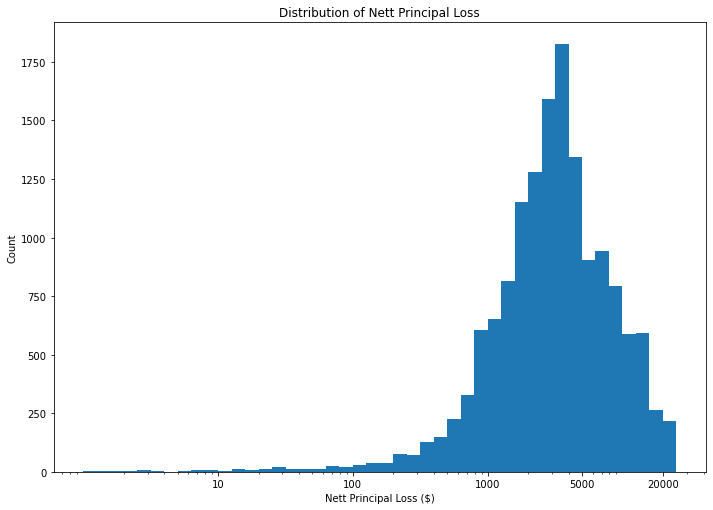

In [31]:
log_binsize = 0.1
bins = 10 ** np.arange(0, np.log10(df['LP_NetPrincipalLoss'].max())+log_binsize, log_binsize)

plt.figure(figsize=[11.69, 8.27])
plt.hist(data=df, x='LP_NetPrincipalLoss', bins=bins)
plt.xscale('log')
plt.xticks([10, 100, 1000, 5000, 20000], [10, 100, 1000, 5000, 20000])
#plt.xticks([500, 1e3, 2e3, 5e3, 1e4, 2e4], [500, '1k', '2k', '5k', '10k', '20k'])
plt.xlabel('Nett Principal Loss ($)')
plt.ylabel('Count')
plt.title('Distribution of Nett Principal Loss');

## ## Distribution of Debt-to-Income Ratio

> In comparison with Nett Principal Loss distribution, the distribution of Debt-to-Income Ratio is skewed to the right. Unexpectedly, a large proportion of the data points falls below 0.4 which means that majority of irrecoverable loans came from people with healthy Debt-to-Income Ratio. This signals that having low Debt-to-Income Ratio does not necessarily mean that they will be able to repay their loans without fail.

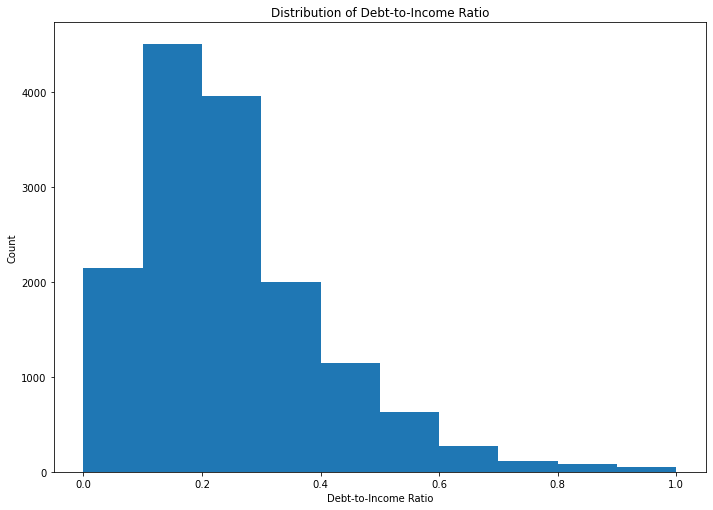

In [32]:
binsize = 0.1
bins = np.arange(0, df['DebtToIncomeRatio'].max()+binsize, binsize)

plt.figure(figsize=[11.69, 8.27])
plt.hist(data=df, x ='DebtToIncomeRatio', bins=bins)
plt.xlabel('Debt-to-Income Ratio')
plt.ylabel('Count')
plt.title('Distribution of Debt-to-Income Ratio');

## ## Nett Principal Loss vs Debt-to-Income Ratio

> There seems to be no correlation between Nett Principal Loss and Debt-to-Income Ratio. Most borrowers with irrecoverable loans are having Debt-to-Income Ratio under 0.4 which is considered as healthy ratio. Most irrecoverable losses are ranging between 2,000 and 4,000. 

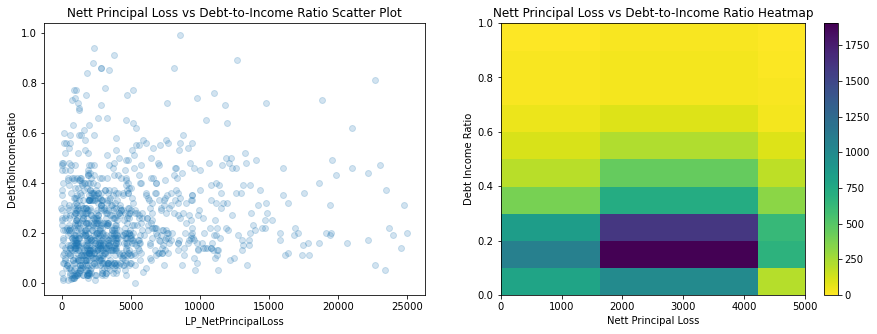

In [43]:
plt.figure(figsize=[15,5])

plt.subplot(1, 2, 1)
df_sample=df.sample(1000)
sb.regplot(data=df_sample, x='LP_NetPrincipalLoss', y='DebtToIncomeRatio', truncate=False, fit_reg=False, 
           scatter_kws={'alpha':1/5})
plt.title('Nett Principal Loss vs Debt-to-Income Ratio Scatter Plot')

plt.subplot(1, 2, 2)
plt.hist2d(data=df, x='LP_NetPrincipalLoss', y='DebtToIncomeRatio', cmap = 'viridis_r')
plt.xlim(0,5000)
plt.colorbar()
plt.xlabel('Nett Principal Loss')
plt.ylabel('Debt Income Ratio')
plt.title('Nett Principal Loss vs Debt-to-Income Ratio Heatmap');

## ## Nett Principal Loss vs Credit Rating & Income Range

> The box plots show increasing trend of Nett Principal Loss with better credit rating and higher income range. Furthermore, the data distribution can be observed through the violin plot. It appears that the distribution of Nett Principal Loss is getting slimmer as the Credit Rating gets higher. This is also true when Income Range gets higher. 

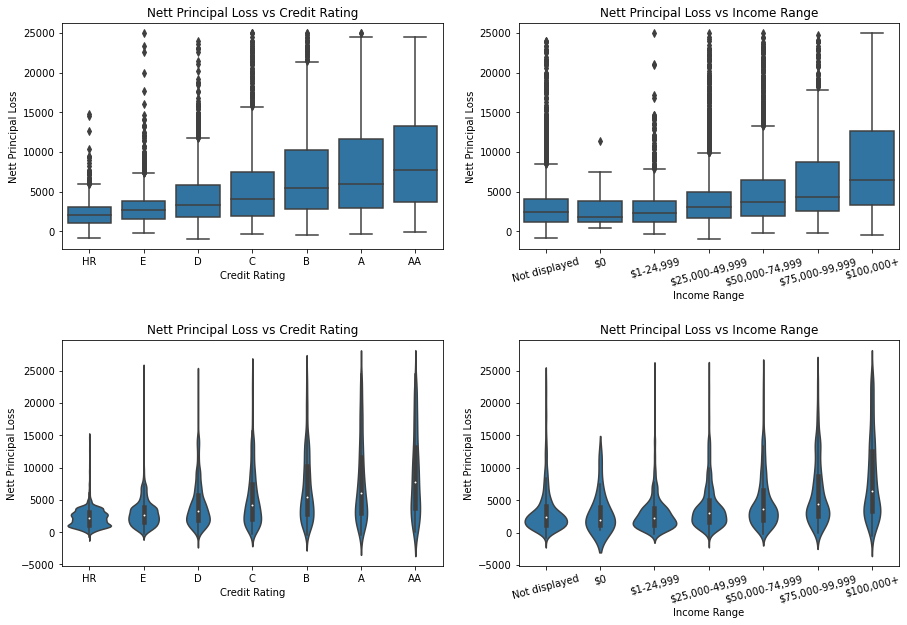

In [71]:
base_color = sb.color_palette()[0]
plt.figure(figsize = [15, 10])

plt.subplot(2, 2, 1)
sb.boxplot(data = df, x='CreditRatingCombined', y='LP_NetPrincipalLoss', color=base_color)
plt.title('Nett Principal Loss vs Credit Rating')
plt.xlabel('Credit Rating')
plt.ylabel('Nett Principal Loss')

plt.subplot(2, 2, 2)
sb.boxplot(data = df, x='IncomeRange', y='LP_NetPrincipalLoss', color=base_color)
plt.title('Nett Principal Loss vs Income Range')
plt.xticks(rotation=15)
plt.xlabel('Income Range')
plt.ylabel('Nett Principal Loss')

plt.subplot(2, 2, 3)
sb.violinplot(data = df, x='CreditRatingCombined', y='LP_NetPrincipalLoss', color=base_color)
plt.title('Nett Principal Loss vs Credit Rating')
plt.xlabel('Credit Rating')
plt.ylabel('Nett Principal Loss')

plt.subplot(2, 2, 4)
sb.violinplot(data = df, x='IncomeRange', y='LP_NetPrincipalLoss', color=base_color)
plt.title('Nett Principal Loss vs Income Range')
plt.xticks(rotation=15)
plt.xlabel('Income Range')
plt.ylabel('Nett Principal Loss')

plt.subplots_adjust(hspace=0.4);

## ## Nett Principal Loss & Debt-to-Income Ratio vs Income Range

> It is interesting to find that most irrecoverable losses came from the group of people with income range between 25,000 and 74,999. A sizeable amount of loss also came from the group of people who did not disclose their income range. It may be the case that they disclosed their employment status and occupation, but not their income range. This evidence suggests that income range is an important factor to consider loan approval.

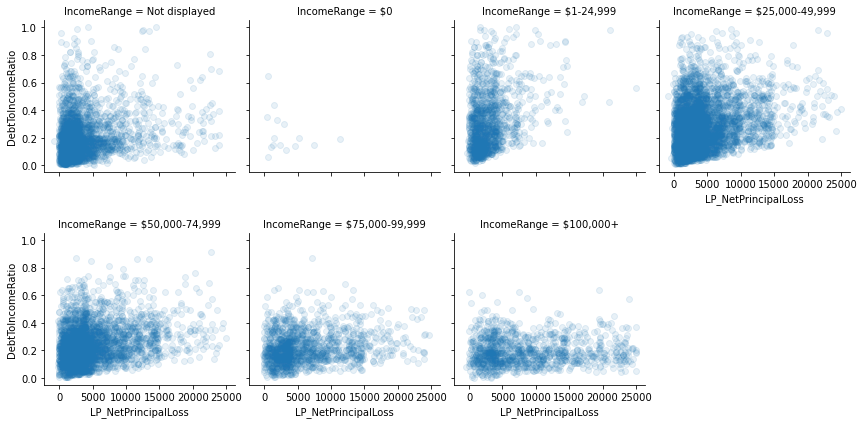

In [77]:
g = sb.FacetGrid(data = df, col = 'IncomeRange', col_wrap = 4, size = 3, margin_titles = True)
g.map(plt.scatter, 'LP_NetPrincipalLoss', 'DebtToIncomeRatio', alpha=1/10)
plt.subplots_adjust(hspace=0.4);